<h2>1. Overview</h2>

As stated in the description, the data for this competition comes from a experimental set-up used to study earthquake physics. Our goal is to predict the time remaining before the next laboratory earthquake. The only feature we have is the seismic signal (acoustic data), which is recorded using a piezoceramic sensor and corresponds to the voltage upon deformation (in integers).

* Training data: single, continuous segment of experimental data.

* Test data: consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment.

* Both the training and the testing set come from the same experiment.

* There is no overlap between the training and testing sets.

There are a lot of files in this competition, so let's start with the folders structure:

In [1]:
import os
from random import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numba
import warnings
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

@numba.jit
def get_stats(arr):
    """Memory efficient stats (min, max and mean). """
    size  = len(arr)
    min_value = max_value = arr[0]
    mean_value = 0
    for i in numba.prange(size):
        if arr[i] < min_value:
            min_value = arr[i]
        if arr[i] > max_value:
            max_value = arr[i]
        mean_value += arr[i]
    return min_value, max_value, mean_value/size

@numba.jit
def get_diff(arr, threshold):
    """Find uniques ttf differences between rows. """
    diff_list = []
    size  = len(arr)
    uniques = 0
    for i in numba.prange(size - 1):
        diff = abs(arr[i+1] - arr[i])
        if uniques == 0:
            diff_list.append(diff)
            uniques += 1
        else:
            for j in numba.prange(uniques):
                if abs(diff - diff_list[j]) < threshold or abs(diff - diff_list[j]) > 1:
                    break
            else:
                diff_list.append(diff)
                uniques += 1
    return diff_list

In [2]:
print(os.listdir("../input/"))

['test', 'sample_submission.csv', 'train.csv']


The test folder has many csv files:

In [3]:
test_folder_files = os.listdir("../input/test")
print(test_folder_files[:10])  # print first 10
print("\nNumber of files in the test folder", len(test_folder_files))

['seg_d5df41.csv', 'seg_abda04.csv', 'seg_421a96.csv', 'seg_d31583.csv', 'seg_14c054.csv', 'seg_e2b8b1.csv', 'seg_166f70.csv', 'seg_a7b454.csv', 'seg_a9a820.csv', 'seg_bd4d30.csv']

Number of files in the test folder 2624


There is one file in the test folder for each prediction (seg_id) in sample_submission:

In [4]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
print("Submission shape", sample_sub.shape)
sample_sub.head()

Submission shape (2624, 2)


,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


<h2>2. Training data</h2>

One huge csv file has all the training data, which is a single continuous experiment. There are only two columns in this file:
* Acoustic data (int16): the seismic signal
* Time to failure (float64): the time until the next laboratory earthquake  (in seconds)
* **No missing values for both columns**

In [5]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print("train shape", train.shape)
pd.set_option("display.precision", 15)  # show more decimals
train.head()

train shape (629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


<h3>2.1 Acoustic Data</h3>

Our single feature are integers in the range [-5515, 5444] with mean 4.52

In [8]:
pd.set_option("display.precision", 8)
train.acoustic_data.describe()

count    6.29145480e+08
mean     4.51946757e+00
std      1.07357072e+01
min     -5.51500000e+03
25%      2.00000000e+00
50%      5.00000000e+00
75%      7.00000000e+00
max      5.44400000e+03
Name: acoustic_data, dtype: float64

The plot below is using a 1% random sample (~6M rows):

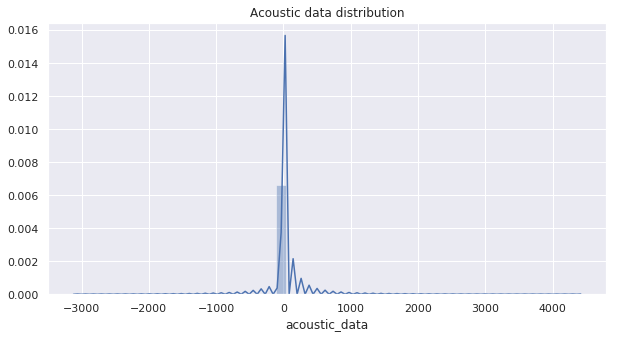

In [9]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train_sample.acoustic_data, label='Train (1% sample)')

There are outliers in both directions; let's try to plot the same distribution with the range -25 to 25. The black line is the closest normal distribution (gaussian) possible.

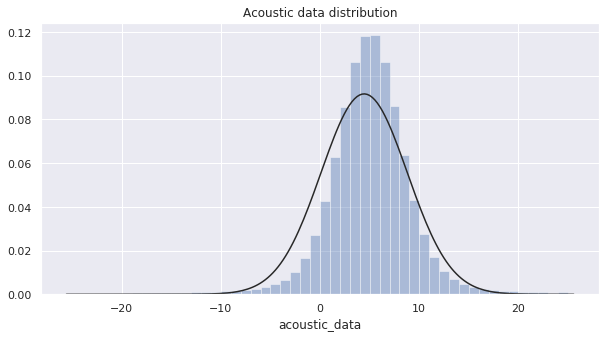

In [10]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
ax = sns.distplot(tmp, label='Train (1% sample)', kde=False, fit=stats.norm)

<h3>2.2 Time to Failure</h3>

The target variable is given in seconds with a max value of 16 seconds and minimun value close to zero (1e-5).

In [11]:
tmin, tmax, tmean = get_stats(train.time_to_failure.values)
print("min value: {:.6f}, max value: {:.2f}, mean: {:.4f}".format(tmin, tmax, tmean))

min value: 0.000096, max value: 16.11, mean: 5.6783


Distribution for the random sample:

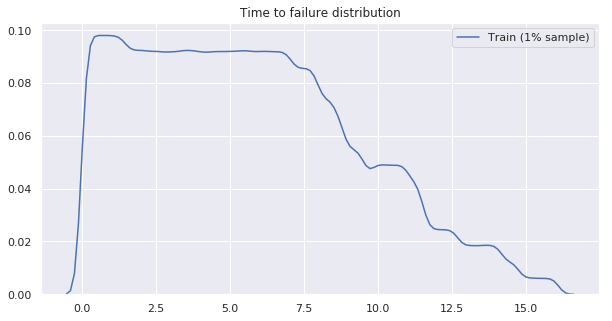

In [12]:
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.kdeplot(train_sample.time_to_failure, label='Train (1% sample)')

<h3>2.3 Timeseries</h3>

Let's see how both variables change over time. The next plot has the first thousand rows of data; the orange line is the acoustic data and the blue one is the time to failure:

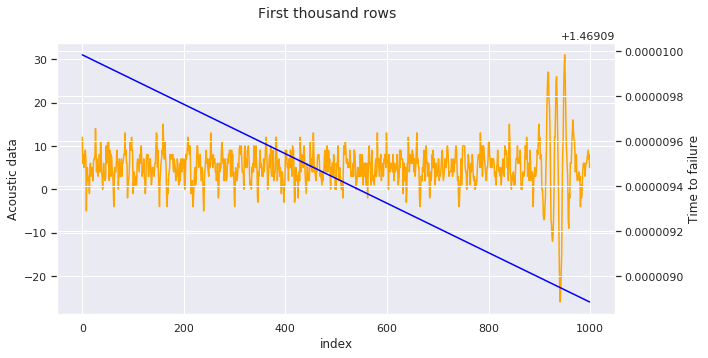

In [13]:
def single_timeseries(final_idx, init_idx=0, step=1, title="",
                      color1='orange', color2='blue'):
    idx = [i for i in range(init_idx, final_idx, step)]
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle(title, fontsize=14)
    
    ax2 = ax1.twinx()
    ax1.set_xlabel('index')
    ax1.set_ylabel('Acoustic data')
    ax2.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx].acoustic_data.values, ax=ax1, color=color1)
    p2 = sns.lineplot(data=train.iloc[idx].time_to_failure.values, ax=ax2, color=color2)


def double_timeseries(final_idx1, final_idx2, init_idx1=0, init_idx2=0, step=1, title=""):
    idx1 = [i for i in range(init_idx1, final_idx1, step)]
    idx2 = [i for i in range(init_idx2, final_idx2, step)]
    
    fig, (ax1a, ax2a) = plt.subplots(1,2, figsize=(12,5))
    fig.subplots_adjust(wspace=0.4)
    ax1b = ax1a.twinx()
    ax2b = ax2a.twinx()
    
    ax1a.set_xlabel('index')
    ax1a.set_ylabel('Acoustic data')
    ax2a.set_ylabel('Time to failure')
    p1 = sns.lineplot(data=train.iloc[idx1].acoustic_data.values, ax=ax1a, color='orange')
    p2 = sns.lineplot(data=train.iloc[idx1].time_to_failure.values, ax=ax1b, color='blue')
    
    p3 = sns.lineplot(data=train.iloc[idx2].acoustic_data.values, ax=ax2a, color='orange')
    p4 = sns.lineplot(data=train.iloc[idx2].time_to_failure.values, ax=ax2b, color='blue')
    
single_timeseries(1000, title="First thousand rows")

The time to failure (TTF) is linearly decreasing at a very slow rate. However, when looking at ten thousand rows it's possible to see some "jumps":

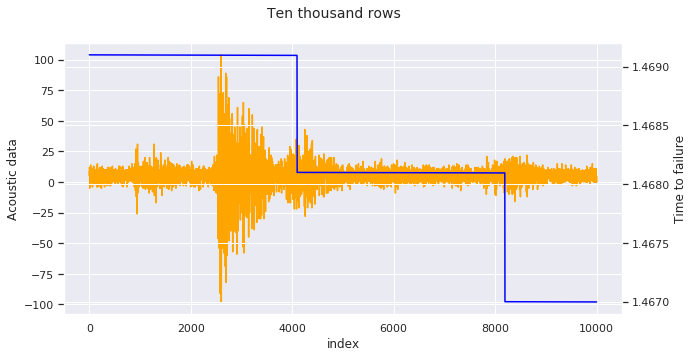

In [17]:
single_timeseries(10000, title="Ten thousand rows")

According to [this discussion](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526):

> The data is recorded in bins of 4096 samples. Within those bins seismic data is recorded at 4MHz, but there is a 12 microseconds (1e-6) gap between each bin, an artifact of the recording device.

Therefore, the "jumps" have 12 microseconds and occur every 4096 measurements. The next plot has ten million rows, but we are plotting only every 10 data points:

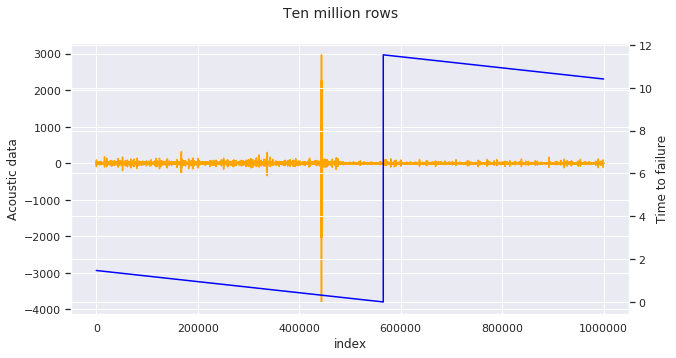

In [20]:
single_timeseries(10000000, step=10, title="Ten million rows")

We can't see the jumps anymore; it's as if we have stretched the line and the steps disappeared. There is only one huge change in TTF, which is exactly when an earthquake occured and the time goes from almost zero to eleven seconds.

Finally, let's plot all the data (629.145 million rows):

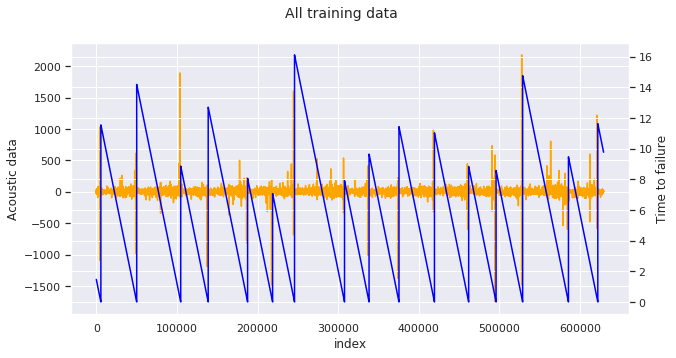

In [21]:
single_timeseries(629145000, step=1000, title="All training data")

There are 16 earthquakes in the training data. The shortest time to failure is 1.5 seconds for the first earthquake and 6s to the 7º, while the longest is around 16 seconds.

In the plot below I just changed the time_to_failure color to white. Now it's possible to see a peak in acoustic data before each earthquake:

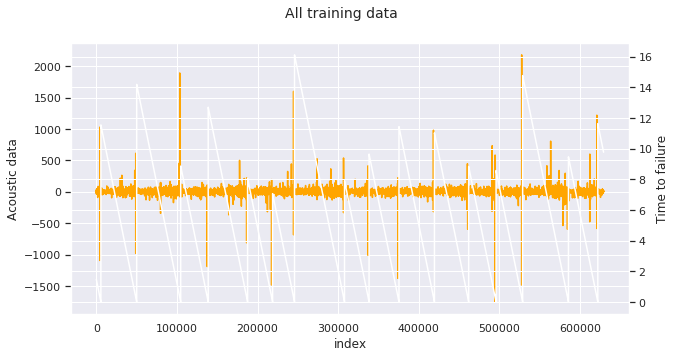

In [22]:
single_timeseries(629145000, step=1000, title="All training data", color2='white')

This is not a perfect rule though: there are some peaks far from earthquakes (e.g. between the 14º and 15º). Another interesting thing to check is the time between these high levels of seismic signal and the earthquakes. I'm considering any acoustic data with **absolute value greater than 500 as a high level:**

In [ ]:
peaks = train[train.acoustic_data.abs() > 500]
peaks.time_to_failure.describe()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution - time to failure with high signal")
ax = sns.distplot(peaks.time_to_failure, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))

**More than 80% of high acoustic values are around 0.31 seconds before an earthquake!**

<h3>2.4 Time between measurements</h3>

Let's have a closer look at the TTF difference between each measurament. I'm using a numba function to find each **unique** difference with a given threshold and ploting the values:

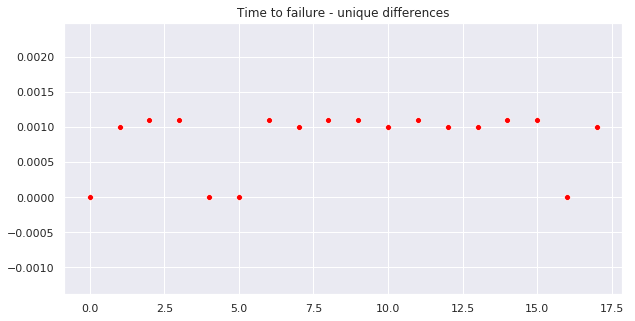

In [31]:
unique_diff = get_diff(train.time_to_failure.values, threshold=1e-10)
plt.figure(figsize=(10,5))
plt.title("Time to failure - unique differences")
ax = sns.scatterplot(x=range(len(unique_diff)), y=unique_diff, color='red')

I'm not sure if the different values are due to numeric precision, but we can see two main ranges; the first around 0.001 and the other very close to zero. The former should be the 12 microseconds between each bin, but it's actually much higher (from 1.2e-5 to 1e-3).  

<h2>3. Test data</h2>

Each file is a segment with 150,000 values for acoustic data (single column). The following distribution is for the first test file:

       acoustic_data
count    150000.0000
mean          4.6716
std           4.7890
min         -71.0000
25%           2.0000
50%           5.0000
75%           7.0000
max          90.0000


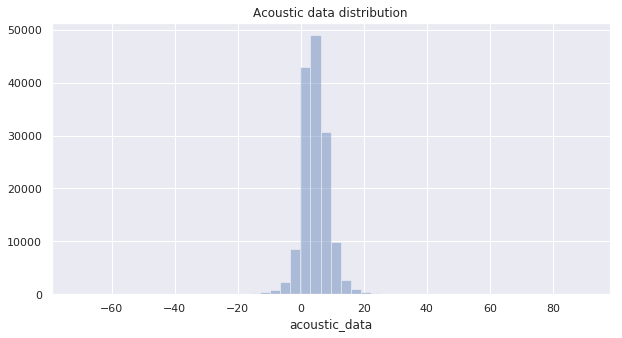

In [32]:
pd.set_option("display.precision", 4)
test1 = pd.read_csv('../input/test/seg_37669c.csv', dtype='int16')
print(test1.describe())
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(test1.acoustic_data, label='seg_37669c', kde=False)

Now the distribution for 10 files choosen at random:

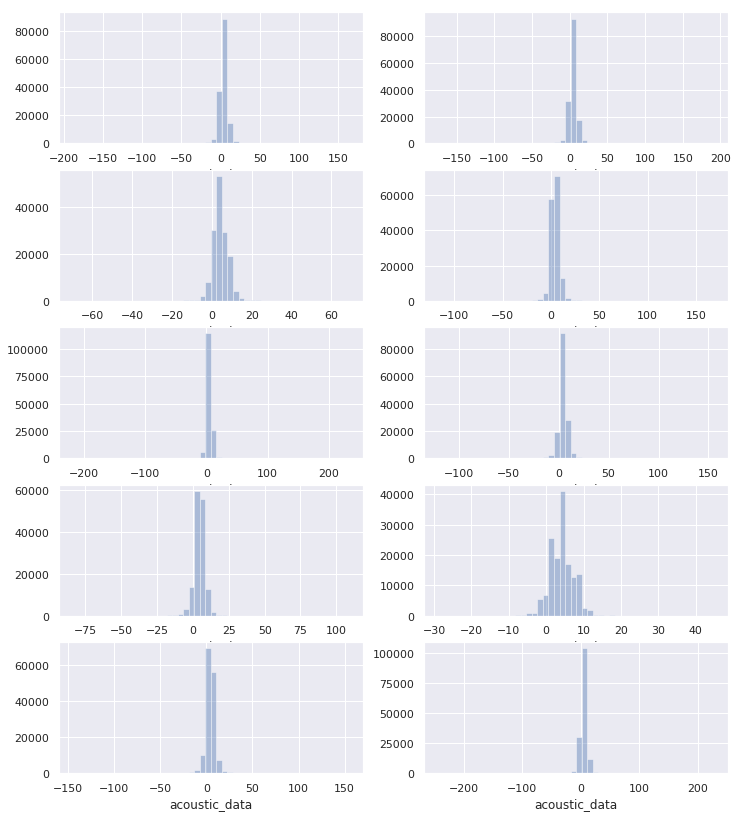

In [33]:
fig, axis = plt.subplots(5, 2, figsize=(12,14))
shuffle(test_folder_files)
xrow = xcol = 0
for f in test_folder_files[:10]:
    tmp = pd.read_csv('../input/test/{}'.format(f), dtype='int16')
    ax = sns.distplot(tmp.acoustic_data, label=f.replace('.csv',''), ax=axis[xrow][xcol], kde=False)
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

Timeseries (index as x-axis) for the same ten files:

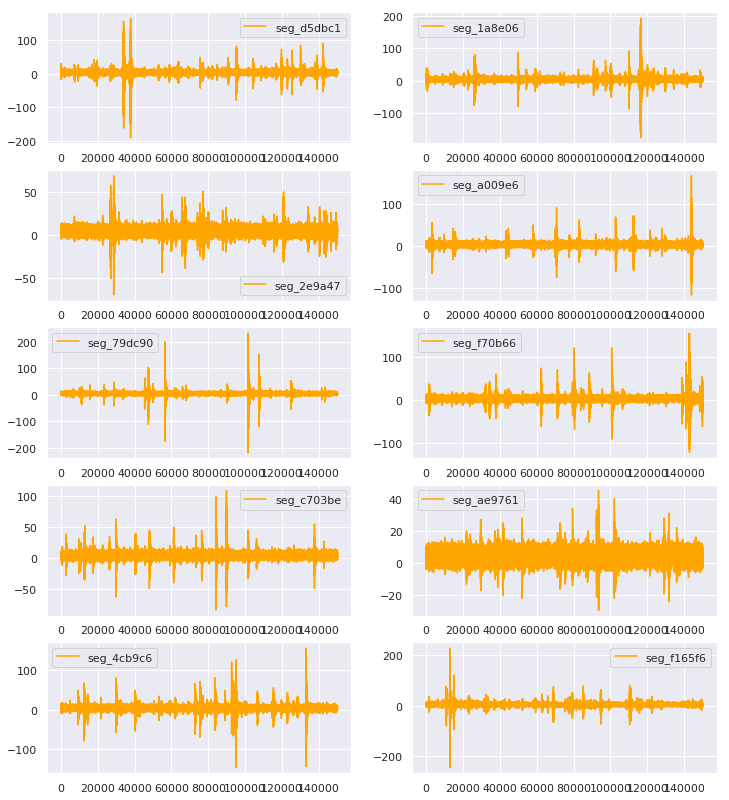

In [34]:
fig, axis = plt.subplots(5, 2, figsize=(12,14))
xrow = xcol = 0
for f in test_folder_files[:10]:
    tmp = pd.read_csv('../input/test/{}'.format(f), dtype='int16')
    ax = sns.lineplot(data=tmp.acoustic_data.values,
                      label=f.replace('.csv',''),
                      ax=axis[xrow][xcol],
                      color='orange')
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

<h2>4. Statistics for chunks</h2>

<h3>4.1 Rolling mean</h3>
Most kernels are grouping the training data every 150,000 rows and calculating statistics about that chunk. The next plot shows the **mean absolute value for every 150,000 data points** and the** time to failure for the last point within each chunk**.

In [ ]:
rolling_mean = []
rolling_std = []
last_time = []
init_idx = 0
for _ in range(4194):  # 629M / 150k = 4194
    x = train.iloc[init_idx:init_idx + 150000]
    last_time.append(x.time_to_failure.values[-1])
    rolling_mean.append(x.acoustic_data.abs().mean())
    rolling_std.append(x.acoustic_data.abs().std())
    init_idx += 150000
    
rolling_mean = np.array(rolling_mean)
last_time = np.array(last_time)

# plot rolling mean
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean for chunks with 150k samples of training data', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean, ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

Removing high values (mean value less than 8):

In [ ]:
# plot rolling mean
fig, ax1 = plt.subplots(figsize=(10, 5))
fig.suptitle('Mean (< 8) for chunks of 150k samples', fontsize=14)

ax2 = ax1.twinx()
ax1.set_xlabel('index')
ax1.set_ylabel('Acoustic data')
ax2.set_ylabel('Time to failure')
p1 = sns.lineplot(data=rolling_mean[rolling_mean < 8], ax=ax1, color='orange')
p2 = sns.lineplot(data=last_time, ax=ax2, color='gray')

We can see that the mean absolute value is increasing as we get closer to an earthquake.

<h3>4.2 Standard deviation</h3>

In the next chart, the standard deviation for each chunk was grouped by the time to failure, which in turn was rounded to the first decimal place.

In [ ]:
frame = pd.DataFrame({'rolling_std': rolling_std, 'time': np.around(last_time, 1)})
s = frame.groupby('time').rolling_std.mean()
s = s[s < 20]  # remove one outlier
plt.figure(figsize=(10, 5))
plt.title("Std for chunks with 150k samples of training data")
plt.xlabel("Time to failure")
plt.ylabel("Acoustic data")
ax = sns.lineplot(x=s.index, y=s.values)

The standard deviation is also higher for chunks that are closer to an earthquake (in general).